In [1]:
import matplotlib.pyplot as plt
from tueplots import bundles
import numpy as np
import pandas as pd
import os

from tueplots.constants.color.palettes import paultol_light, paultol_muted, tue_primary
def turn_to_np_rgb(hex_color, coloration=1):
    return (np.array( list(bytes.fromhex(hex_color)) )/ 255.0)*coloration

In [2]:
df_full_range = pd.read_csv('../../dat/hysteresis/hysteresis_up.csv', index_col=0).groupby(['ascending', 'finestep', 'range_exponent', 'start', 'direction']).aggregate({'counter': 'mean'}).reset_index()
df_full_range = df_full_range[(df_full_range['range_exponent'] == 16) & (df_full_range['direction'] == 'up')]
df_full_range['counter'] = 2 * (df_full_range['counter'] - df_full_range['counter'].min()) / (df_full_range['counter'].max() - df_full_range['counter'].min()) - 1
df_full_range['finestep'] = df_full_range['finestep'] / np.power(2, 16) * 160
# remove rows where direction is down
df_full_range_up = df_full_range[df_full_range['ascending'] == True]
df_full_range_down = df_full_range[df_full_range['ascending'] == False]
# reverse the "down" data
df_full_range_down['counter'] = df_full_range_down['counter'].values[::-1]
df_full_range_down['finestep'] = df_full_range_down['finestep'].values[::-1]
# concatenate the two dataframes
df_full_range = pd.concat([df_full_range_up, df_full_range_down], ignore_index=True)

offset = 5000
df_random_walk = pd.read_csv('../../dat/walks/random_walk_180min.csv').iloc[offset:offset+16384]
df_random_walk['c_mean'] = 2 * (df_random_walk['c_mean'] - df_random_walk['c_mean'].min()) / (df_random_walk['c_mean'].max() - df_random_walk['c_mean'].min()) - 1
df_random_walk['finestep'] = df_random_walk['finestep'] / np.power(2, 16) * 160
df_random_walk.reset_index(drop=True, inplace=True)

df_spiral = pd.read_csv('../../dat/hysteresis/hysteresis_display.csv', index_col=0)
df_spiral['counter'] = 2 * (df_spiral['counter'] - df_spiral['counter'].min()) / (df_spiral['counter'].max() - df_spiral['counter'].min()) - 1
df_spiral['finestep'] = df_spiral['finestep'] / np.power(2, 16) * 160

C:\Users\David\AppData\Local\Temp\ipykernel_8996\430784723.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_full_range_down['counter'] = df_full_range_down['counter'].values[::-1]
C:\Users\David\AppData\Local\Temp\ipykernel_8996\430784723.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_full_range_down['finestep'] = df_full_range_down['finestep'].values[::-1]


C:\Users\David\AppData\Local\Temp\ipykernel_8996\2264228608.py:52: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


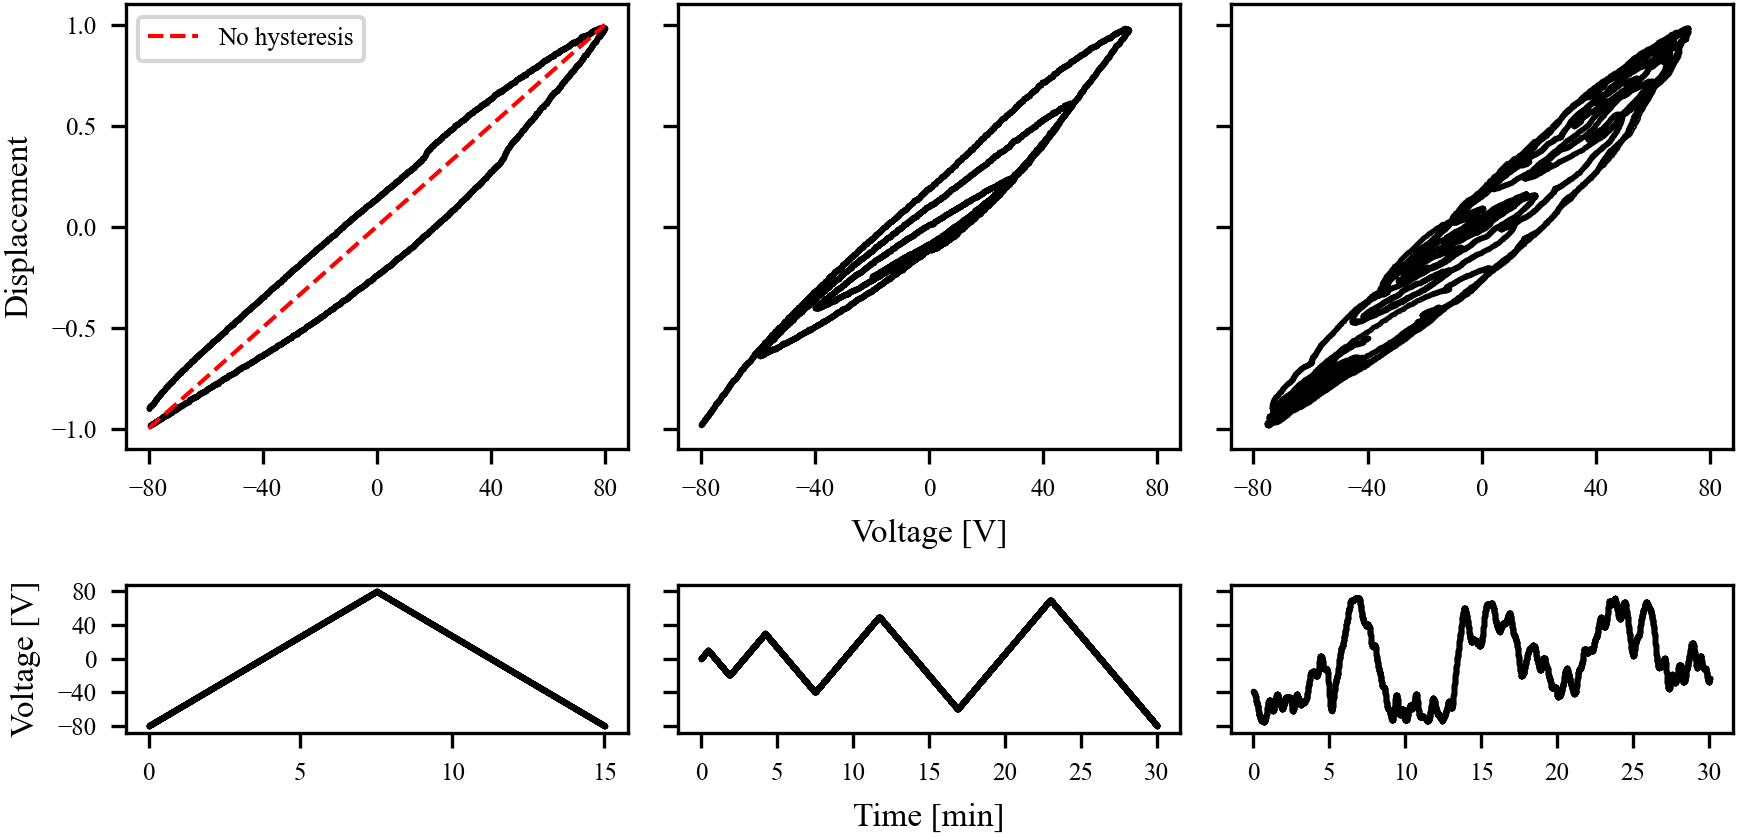

In [3]:
plt.rcParams.update({"figure.dpi": 300})
plt.rcParams.update(bundles.icml2022(column="full", family="serif", usetex=False, nrows=1, ncols=1))
plt.rcParams['font.serif'] = "Times New Roman"

data = [(df_full_range['counter'], df_full_range['finestep']),
        (df_spiral['counter'], df_spiral['finestep']),
        (df_random_walk['c_mean'], df_random_walk['finestep'])]

msz = 0.3
lw = .5
alph = .8
alph_fill = 0.5

fig, axs = plt.subplots(2, 3, height_ratios=[3, 1], figsize=(6, 3))

for i, (y, x) in enumerate(data):
    ax = axs[0, i % 3]
    ax.plot(x, -y.rolling(16).mean(), marker='o', markersize=msz, linewidth=lw, alpha=alph, ls='-', color='black')

    ax.set_xlim(-88, 88)
    ax.set_ylim(-1.1, 1.1)
    ax.set_yticks([-1, -0.5, 0, 0.5, 1])
    ax.set_xticks([-80, -40, 0, 40, 80])

    ax2 = axs[1, i % 3]
    ax2.plot(x, marker='o', markersize=msz, linewidth=lw, alpha=alph, ls='-', color='black')
    ax2.set_ylim(-88, 88)
    ax2.set_yticks([-80, -40, 0, 40, 80])
    ax2.set_xticks(np.arange(0, len(x), 60*5/0.11))
    ax2.set_xticklabels([f'{x * 0.11 / 60:.0f}' for x in ax2.get_xticks()])

    # remove y-axis labels for all but the first plot
    if i == 0:
        ax.set_ylabel('Displacement')
        ax2.set_ylabel('Voltage [V]')
        ax.plot([-80, 80], [-1, 1], color='red', ls='--', lw=1, label='No hysteresis')
        ax.legend(loc='upper left')

    if i == 1:
        ax.set_xlabel('Voltage [V]')
        ax2.set_xlabel('Time [min]')
    if i % 3 != 0:
        ax.set_yticklabels([])
        ax2.set_yticklabels([])

#fig.text(0.5, 0, 'Time', ha='center')
#fig.text(0, 0.66, 'Displacement', va='center', rotation='vertical')
#fig.text(0, 0.2, 'Voltage', va='center', rotation='vertical')



plt.tight_layout()
plt.savefig('./fig_hysteresis.pdf')
plt.show()

C:\Users\David\AppData\Local\Temp\ipykernel_8996\2054926808.py:36: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


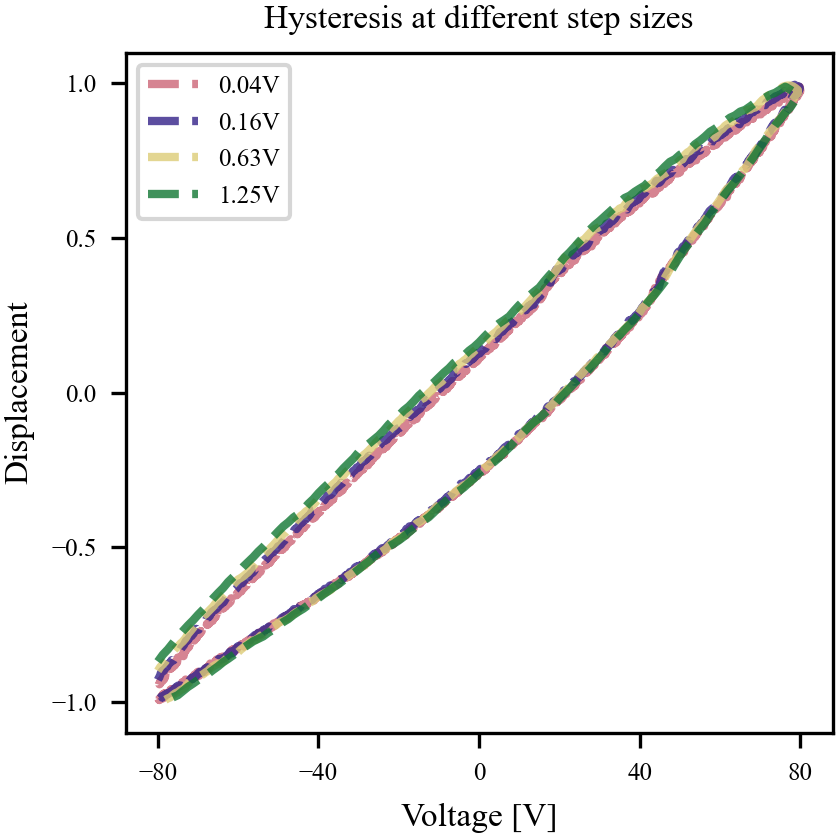

In [64]:
data = {}
for file in os.listdir('../../dat/hysteresis/'):
    if file.startswith('fr') and file.endswith('.csv'):
        stepsize = file.split('_')[1].split('.')[0]
        data[stepsize] = pd.read_csv(f'../../dat/hysteresis/{file}')
# only take keys [4, 16, 64, 256]
data = {key: value for key, value in data.items() if key in ['16', '64', '256', '512']}

voltage_steps_label = ['0.04V', '0.16V', '0.63V', '1.25V']

plt.rcParams.update({"figure.dpi": 300})
plt.rcParams.update(bundles.icml2022(column="full", family="serif", usetex=False, nrows=1, ncols=1))
plt.rcParams['font.serif'] = "Times New Roman"

fig, ax = plt.subplots(1, 1, figsize=(3, 3))

for i, (key, value) in enumerate(sorted(data.items(), key=lambda x: int(x[0]))):
    x_concat = pd.concat([value['finestep'], value['finestep'].iloc[::-1]])
    x_concat = x_concat / np.power(2, 16) * 160
    y_concat = pd.concat([value['ca_mean'], value['cd_mean'].iloc[::-1]])
    # norm the y data to [-1, 1]
    y_concat = 2 * (y_concat - y_concat.min()) / (y_concat.max() - y_concat.min()) - 1
    ax.plot(x_concat, -y_concat.rolling(window=4).mean(), label=voltage_steps_label[i], color=turn_to_np_rgb(paultol_muted[i], 1), linewidth=2, linestyle='--', alpha=0.8)

ax.set_xlim(-88, 88)
ax.set_ylim(-1.1, 1.1)
ax.set_yticks([-1, -0.5, 0, 0.5, 1])
ax.set_xticks([-80, -40, 0, 40, 80])

ax.set_ylabel('Displacement')
ax.set_xlabel('Voltage [V]')
# set title to "Hysteresis at different step sizes"
ax.set_title('Hysteresis at different step sizes')

ax.legend()
plt.tight_layout()
plt.savefig('./fig_hysteresis_stepsize.pdf')
plt.show()

C:\Users\David\AppData\Local\Temp\ipykernel_8996\1329513285.py:38: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


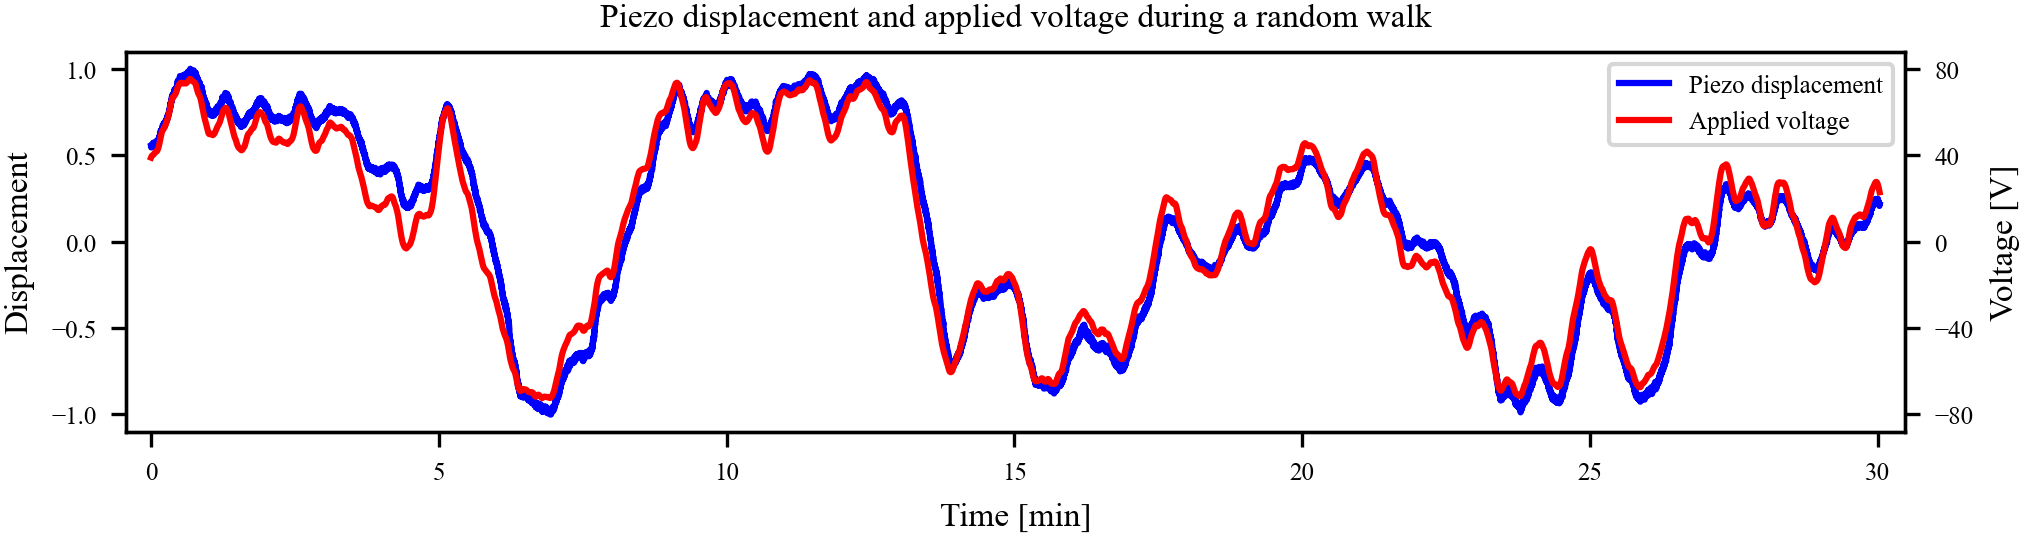

In [21]:
# df_random_walk = pd.read_csv('../../dat/walks/random_walk_180min.csv')
# df_random_walk['c_mean'] = 2 * (df_random_walk['c_mean'] - df_random_walk['c_mean'].min()) / (df_random_walk['c_mean'].max() - df_random_walk['c_mean'].min()) - 1
# df_random_walk['finestep'] = df_random_walk['finestep'] / np.power(2, 16) * 160
# df_random_walk.reset_index(drop=True, inplace=True)

fig, ax = plt.subplots(figsize=(7, 2))

dispalcement = df_random_walk['c_mean']
dispalcement = 2 * (dispalcement - dispalcement.min()) / (dispalcement.max() - dispalcement.min()) - 1

ax.title.set_text('Piezo displacement and applied voltage during a random walk')
ax.plot(dispalcement, label='Piezo displacement', color='blue')
ax2 = ax.twinx()
ax2.plot(-df_random_walk['finestep'], label='Applied voltage', color='red')

# create an vline for the start of the creep measurement
# ax.axvline(x=60*33/0.11, color='black', linestyle='--', label='Start of creep measurement')

minutes_offset = 0
ax.set_ylim(-1.1, 1.1)
ax.set_xlim(60*minutes_offset/0.11-4*60, df_random_walk['c_mean'].shape[0]+4*60)
ax.set_xticks(np.arange(60*minutes_offset/0.11, len(dispalcement), 60*5/0.11))
ax.set_xticklabels([f'{x * 0.11 / 60:.0f}' for x in ax2.get_xticks()])

ax2.set_ylim(-88, 88)
ax2.set_yticks([-80, -40, 0, 40, 80])

ax.set_ylabel('Displacement')
ax2.set_ylabel('Voltage [V]')
ax.set_xlabel('Time [min]')

lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax.legend(lines + lines2, labels + labels2)


# save the figure
plt.tight_layout()
plt.savefig('./random_walk_capture.pdf')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
C:\Users\David\AppData\Local\Temp\ipykernel_8996\2606371295.py:51: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


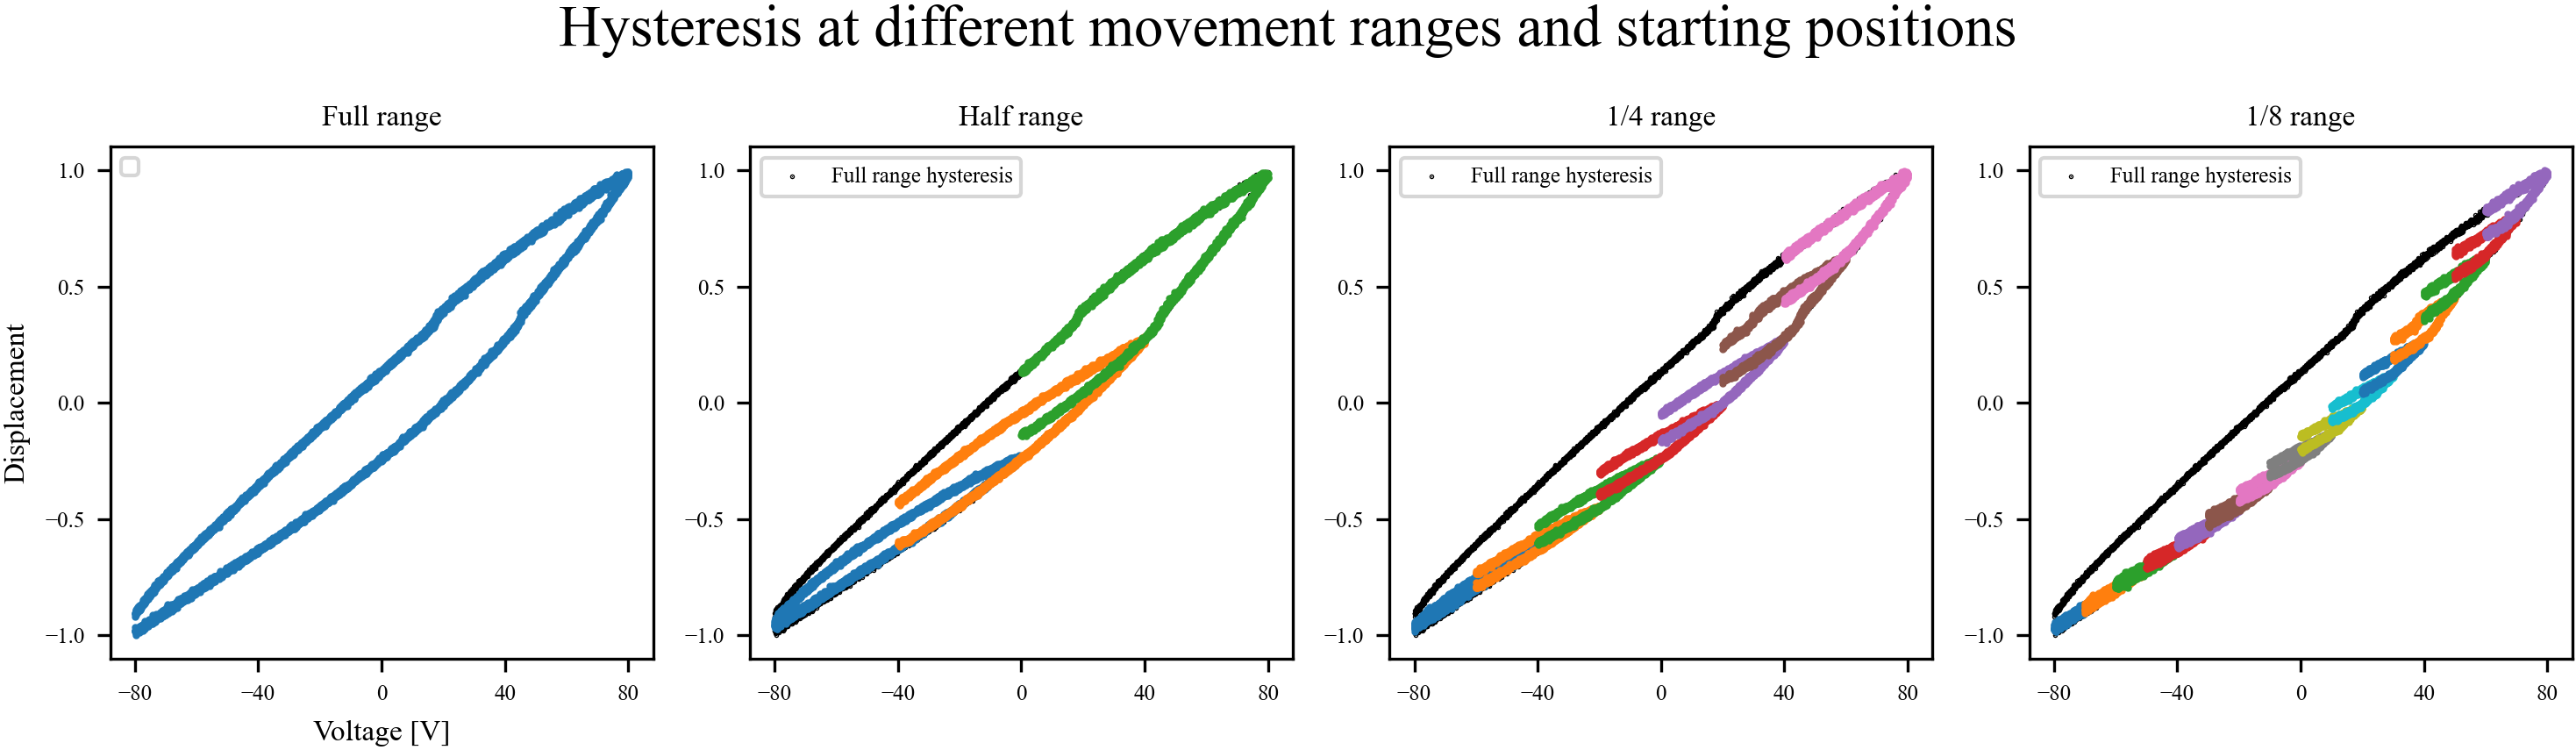

In [50]:
df = pd.read_csv('../../dat/hysteresis/hysteresis_up.csv', index_col=0)
df_mean = df.groupby(['ascending', 'finestep', 'range_exponent', 'start', 'direction']).aggregate({'counter': 'mean'}).reset_index()
df_mean['counter'] = 2 * (df_mean['counter'] - df_mean['counter'].min()) / (df_mean['counter'].max() - df_mean['counter'].min()) - 1
df_mean['finestep'] = df_mean['finestep'] / np.power(2, 16) * 160

df_plot = df_mean

plt.rcParams.update({"figure.dpi": 300})
plt.rcParams.update(bundles.icml2022(column="full", family="serif", usetex=False, nrows=1, ncols=1))
plt.rcParams['font.serif'] = "Times New Roman"

fig, axs = plt.subplots(1, 4, figsize=(10, 3))

plt.suptitle('Hysteresis at different movement ranges and starting positions', fontsize=16)

range16 = df_plot[(df_plot['range_exponent'] == 16) & (df_plot['direction'] == 'up')]
axs[0].scatter(range16['finestep'], -range16['counter'], s=1)
axs[0].set_title('Full range')
axs[1].scatter(range16['finestep'], -range16['counter'], label='Full range hysteresis', s=0.1, color='black')
axs[1].set_title('Half range')
axs[2].scatter(range16['finestep'], -range16['counter'], label='Full range hysteresis', s=0.1, color='black')
axs[2].set_title('1/4 range')
axs[3].scatter(range16['finestep'], -range16['counter'], label='Full range hysteresis', s=0.1, color='black')
axs[3].set_title('1/8 range')

range15 = df_plot[df_plot['range_exponent'] == 15]
for v in range15['start'].unique():
    dat = range15[range15['start'] == v]
    axs[1].scatter(dat['finestep'], -dat['counter'], s=1)

range14 = df_plot[df_plot['range_exponent'] == 14]
for v in range14['start'].unique():
    dat = range14[range14['start'] == v]
    axs[2].scatter(dat['finestep'], -dat['counter'], s=1)

range13 = df_plot[df_plot['range_exponent'] == 13]
for v in range13['start'].unique():
    dat = range13[range13['start'] == v]
    axs[3].scatter(dat['finestep'], -dat['counter'], s=1)

for i, ax in enumerate(axs):
    if i == 0:
        ax.set_xlabel('Voltage [V]')
        ax.set_ylabel('Displacement')
    ax.set_xlim(-88, 88)
    ax.set_ylim(-1.1, 1.1)
    ax.set_yticks([-1, -0.5, 0, 0.5, 1])
    ax.set_xticks([-80, -40, 0, 40, 80])
    ax.legend()

plt.tight_layout()
plt.savefig('./fig_hysteresis_ranges.pdf')